# Linear Programming: Multi Commodity Production Planning

By: Mansur M. Arief

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/analytics-project-simt-its/analytics-project-simt-its.github.io/blob/main/notebooks/pyomo_multi-commodity_production_planning.ipynb)

In [1]:
# Constants
EXCEL_FILE = 'PPIC_input.xlsx' # excel file name

In [2]:
%pip install pyomo
%pip install gurobipy
%pip install openpyxl
!apt-get install -y -qq glpk-utils

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
zsh:1: command not found: apt-get


In [3]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import matplotlib.pyplot as plt

# Model

Objective: find the product grades to maximize profits


Set:
- $I$: set of grade types
- $J$: set of raw materials
- $K$: set of processing methods
- $T$: set of time periods


Parameter:
- $p_i$: price of grade $i$
- $d_{it}$: demand of grade $i$ at time $t$
- $m_{ik}$: 1 if grade $i$ can be produced by processing method $k$, 0 otherwise
- $n_{ijk}$: quantity of raw material $j$ needed to produce 1 ton of grade $i$ by processing method $k$
- $c_j$: cost of raw material $j$
- $h_j$: holding cost of raw material $j$
- $s_i$: holding cost for grade $i$
- $r_j$: reorder cost for raw material $j$
- $b$: bagging cost/ton (in USD)
- $t_{ik}$: time to produce 1 ton of grade $i$ by processing method $k$
- $e_{ik}$: energy consumption to produce 1 ton of grade $i$ by processing method $k$
- $u^{min}, u^{max}$: min and max material to order 
- $M_{ik}$ : production capacity of processing method $k$ for grade $i$
- BigM : 99999
- $Cap_k$: capacity of processing method $k$

Variable:
- $x_{ikt}$: quantity of grade $i$ produced by processing method $k$ at time $t$
- $y_{it}$: quantity of grade $i$ in stock at time $t$
- $z_{it}$: quantity of grade $i$ sold at time $t$
- $w_{jt}$: indicator variable if raw material $j$ ordered at time $t$
- $u_{jt}$: quantity of raw material $j$ ordered at time $t$
- $v_{jt}$: quantity of raw material $j$ in stock at time $t$




Objective function:

maximize profit = revenue - (cost of energy/utility + cost of manpower + cost of bagging + cost of holding products inventory + cost of raw materials + cost of holding raw materials inventory + cost of reordering materials)


- Revenue: $\sum_{i \in I} \sum_{t \in T} p_i z_{it}$
- Cost of energy/utility: $\sum_{i \in I} \sum_{k \in K} \sum_{t \in T} e_{ik} x_{ikt}$
- Cost of manpower: $\sum_{i \in I} \sum_{k \in K} \sum_{t \in T} t_{ik} x_{ikt}$
- Cost of bagging: $\sum_{i \in I} \sum_{k \in K} \sum_{t \in T} b x_{ikt}$
- Cost of holding products inventory: $\sum_{i \in I} \sum_{t \in T} s_i y_{it}$
- Cost of raw materials: $\sum_{j \in J} \sum_{t \in T} c_j u_{jt}$
- Cost of holding raw materials inventory: $\sum_{j \in J} \sum_{t \in T} h_j v_{jt}$
- Cost of reordering materials: $\sum_{j \in J} \sum_{t \in T} w_{jt} r_{j}$


$$\begin{aligned}
\text{maximize}_{\mathbf x, \mathbf y, \mathbf z, \mathbf u, \mathbf v} 
& \quad \bigg( \sum_{i \in I} \sum_{t \in T} p_i z_{it} \bigg) - \bigg( \sum_{i \in I} \sum_{k \in K} \sum_{t \in T} (e_{ik} - t_{ik} - b )x_{ikt} \bigg) - \bigg( \sum_{i \in I} \sum_{t \in T}  s_i y_{it} \bigg) - \bigg( \sum_{j \in J} \sum_{t \in T} (c_j  u_{jt} + h_j v_{jt} + w_{jt} r_j )\bigg) \\
\end{aligned}$$



In [4]:
# Load data
df_material = pd.read_excel(EXCEL_FILE, sheet_name='Materials')
df_grade = pd.read_excel(EXCEL_FILE, sheet_name='Products')
df_process = pd.read_excel(EXCEL_FILE, sheet_name='Processes')
param = pd.read_excel(EXCEL_FILE, 
                         sheet_name='ProblemParameters', 
                         index_col=0
                         ).iloc[0,:].to_dict()

In [5]:
# Helper functions
def get_problem_param(param_name, file=EXCEL_FILE):
    try:
        return pd.read_excel(file, sheet_name=param_name, index_col=0).values
    except:
        print(f'Could not find {param_name} in {file}.')
        return None
    
def get_param(param_name, df):
    try:
        return df[param_name].values
    except:
        print(f'Could not find {param_name} in the dataset.')
        return None

def get_material_param(param_name):
    return get_param(param_name, df_material)

def get_grade_param(param_name):
    return get_param(param_name, df_grade)

def get_process_param(param_name):
    return get_param(param_name, df_process)


In [6]:
# Seed for random number generation
np.random.seed(2024) # for reproducibility


# Parameters
n_grades = param['NumGrades'] # number of product grades, i
n_materials = param['NumMaterials'] # number of raw materials, j
n_methods = param['NumProcesses'] # number of processing methods, k
n_periods = param['NumPeriods'] # number of periods, t
b = param['b'] #in USD/ton
usd_to_idr = param['usd_to_idr'] # exchange rate
e_cost = param["ElectricityCost"] #in USD/KWH 
e_bulk = param["ElectricityBulk"] #in KWH/ton
e_util = param["ElectricityUtil"] #in KWH/ton
e_efficiency = param["Efficiency"] # % of electricity used for production
u_min = param["ReorderQtyMin"] # minimum reorder quantity
u_max = param["ReorderQtyMax"] # maximum reorder quantity
big_M = 1e9 # big M value for the model


p_i = get_grade_param("Price")  # price for each product grade
c_j = get_material_param("Cost") # cost for each material
h_j = get_material_param("HoldingCost") # holding cost for each material
r_j = get_material_param("ReorderCost") # reorder cost for each material
s_i = get_grade_param("HoldingCost") # holding cost for each product grade
other_util_ik = get_problem_param("OtherUtilCost") # other utility cost for each method
t_ik = get_problem_param("ProcessingTime") # processing time for each method
y_i1 = get_grade_param("InitInventory") # initial product inventory
v_j1 = get_material_param("InitInventory") # initial raw material inventory
num_lines_k = get_process_param("NumParallelLines") # number of parallel lines for each process
e_k = get_process_param("Electricity") # electricity consumption for each process


# demand for each product grade in each period
d_it = np.column_stack([
    get_grade_param(f'D{i+1}') for i in range(n_periods)
    ]) 

# indicator for whether a product grade is produced by each processing method
m_ik = np.column_stack([
    get_grade_param('PCR1'), 
    get_grade_param('PCR2'), 
    get_grade_param('Granule')
    ])

# composition of each product grade in terms of raw materials
n_ijk=np.hstack(
    (get_problem_param("CompositionPCR1"),
     get_problem_param("CompositionPCR2"),
    get_problem_param("CompositionGranule"))
    ).reshape((n_grades,n_materials,n_methods))

In [7]:
#Instantiate the model
model = pyo.AbstractModel()

# Define the sets
model.I = pyo.RangeSet(n_grades)
model.J = pyo.RangeSet(n_materials)
model.K = pyo.RangeSet(n_methods)
model.T = pyo.RangeSet(n_periods)
model.Tplus1 = pyo.RangeSet(2, n_periods)


# Define the decision variables
model.x = pyo.Var(model.I, model.K, model.T, within=pyo.NonNegativeReals)
model.y = pyo.Var(model.I, model.T, within=pyo.NonNegativeReals)
model.z = pyo.Var(model.I, model.T, within=pyo.NonNegativeReals)
model.w = pyo.Var(model.J, model.T, within=pyo.Binary)
model.u = pyo.Var(model.J, model.T, within=pyo.NonNegativeReals)
model.v = pyo.Var(model.J, model.T, within=pyo.NonNegativeReals)


# Define the parameters
model.p = pyo.Param(model.I, initialize=lambda model, i: p_i[i-1])
model.d = pyo.Param(model.I, model.T, initialize=lambda model, i, t: d_it[i-1, t-1])
model.m = pyo.Param(model.I, model.K, initialize=lambda model, i, k: m_ik[i-1, k-1])
model.n = pyo.Param(model.I, model.J, model.K, initialize=lambda model, i, j, k: n_ijk[i-1, j-1, k-1])
model.c = pyo.Param(model.J, initialize=lambda model, j: c_j[j-1])
model.h = pyo.Param(model.J, initialize=lambda model, j: h_j[j-1])
model.r = pyo.Param(model.J, initialize=lambda model, j: r_j[j-1])
model.s = pyo.Param(model.I, initialize=lambda model, i: s_i[i-1])
model.b = pyo.Param(initialize=b)
model.t = pyo.Param(model.I, model.K, initialize=lambda model, i, k: t_ik[i-1, k-1])
model.e_cost = pyo.Param(initialize=e_cost)
model.e_bulk = pyo.Param(initialize=e_bulk)
model.e_util = pyo.Param(initialize=e_util)
model.e_efficiency = pyo.Param(initialize=e_efficiency)
model.e_k = pyo.Param(model.K, initialize=lambda model, k: e_k[k-1])
model.other_util = pyo.Param(model.I, model.K, initialize=lambda model, i, k: other_util_ik[i-1, k-1])
model.u_min = pyo.Param(initialize=u_min)
model.u_max = pyo.Param(initialize=u_max)
model.y_i1 = pyo.Param(model.I, initialize=lambda model, i: y_i1[i-1])
model.v_j1 = pyo.Param(model.J, initialize=lambda model, j: v_j1[j-1])
model.big_M = pyo.Param(initialize=big_M)
model.num_lines = pyo.Param(model.K, initialize=lambda model, k: num_lines_k[k-1])

In [8]:
# Define the objective function
def revenue(model):
    return sum(model.p[i]*model.z[i, t] for i in model.I for t in model.T)

def cost_utility(model):
    bulk = sum(model.e_cost * model.e_bulk * model.e_efficiency * model.x[i,k,t] for i in model.I for k in model.K for t in model.T)
    util = sum(model.e_cost * model.e_util * model.e_efficiency * model.x[i,k,t] for i in model.I for k in model.K for t in model.T)
    prod = sum(model.e_cost * model.e_k[k] * model.e_efficiency * model.x[i,k,t] for i in model.I for k in model.K for t in model.T)
    other_util = sum(model.other_util[i,k] * model.x[i,k,t] for i in model.I for k in model.K for t in model.T)
    return bulk + util + prod + other_util

def cost_manpower(model):
    return sum(model.t[i,k]*model.x[i,k,t] for i in model.I for k in model.K for t in model.T)

def cost_bagging(model):
    return sum(model.b*model.x[i,k,t] for i in model.I for k in model.K for t in model.T)

def cost_inventory_product(model):
    return sum(model.s[i]* model.y[i,t] for i in model.I for t in model.T)

def cost_material(model):
    return sum(model.c[j]*model.u[j,t] for j in model.J for t in model.T)

def cost_inventory_material(model):
    return sum(model.h[j]*model.v[j,t] for j in model.J for t in model.T)

def cost_reorder_inventory(model):
    return sum(model.r[j]*model.w[j,t] for j in model.J for t in model.T)

def objective_rule(model):
    return revenue(model) - cost_utility(model) - cost_manpower(model) - cost_bagging(model) - cost_inventory_product(model) - cost_material(model) - cost_inventory_material(model) - cost_reorder_inventory(model)
model.Objective = pyo.Objective(rule=objective_rule, sense=pyo.maximize)

Constraint

- All demand must be satisfied: $z_{it} = d_{it} \quad \forall i \in I, t \in T$
- Product inventory balance: $y_{it} = y_{i(t-1)} + \sum_{k \in K} x_{ikt} - z_{it} \quad \forall i \in I, t \in T$
- Sold product does not exceed what is available: $z_{it} \leq y_{it} + \sum_{k \in K} x_{ikt} \quad \forall i \in I, t \in T$


In [9]:
# Define constraints
def demand_satisfied(model, i, t):
    return model.z[i,t]  ==   model.d[i,t]
model.demand_satisfied = pyo.Constraint(model.I, model.T, rule=demand_satisfied)

def product_inventory_balance(model, i, t):
    return model.y[i,t] == model.y[i,t-1] + sum(model.x[i,k,t-1] for k in model.K) - model.z[i,t-1]
model.product_inventory_balance = pyo.Constraint(model.I, model.Tplus1, rule=product_inventory_balance)

def sales_not_exceed_available(model, i, t):
    return model.z[i,t] <= model.y[i,t] + sum(model.x[i,k,t] for k in model.K)
model.sales_not_exceed_available = pyo.Constraint(model.I, model.T, rule=sales_not_exceed_available)


- Raw material inventory balance: $v_{jt} = v_{j(t-1)} + u_{j(t-1)} - \sum_{k \in K} \sum_{i \in I} n_{ijk} x_{ikt} \quad \forall j \in J, t \in T$

- Production does not exceed available material: $x_{ikt} \leq n_{ijk} v_{jt} \quad \forall i \in I, j \in J, k \in K, t \in T$

- Min order quantity: $u_{jt} \geq u^{min} w_{jt} \quad \forall j \in J, t \in T$


In [10]:
def material_inventory_balance(model, j, t):
    return model.v[j,t] == model.v[j,t-1] + model.u[j, t-1] - sum(model.n[i,j,k]*model.x[i,k,t-1] for i in model.I for k in model.K)
model.material_inventory_balance = pyo.Constraint(model.J, model.Tplus1, rule=material_inventory_balance)

def material_availability(model, j, t):
    return sum(model.n[i,j,k]*model.x[i,k,t-1] for i in model.I for k in model.K) <= model.v[j,t]
model.material_availability = pyo.Constraint(model.J,model.Tplus1, rule=material_availability)

def min_order_quantity(model, j, t):
    return model.u[j,t] >= model.u_min * model.w[j, t]
model.min_order_quantity = pyo.Constraint(model.J, model.T, rule=min_order_quantity)


- Allow quantity only if order: $u_{jt} \leq w_{jt} \text{bigM} \quad \forall j \in J, t \in T$
- Initial product inventory: $y_{i1} = y_{i, init} \quad \forall i \in I$
- Initial material inventory: $v_{j1} = v_{j, init} \quad \forall j \in J$


In [11]:
def zero_quantity_if_not_order(model, j, t):
    return model.u[j,t] <= model.big_M * model.w[j, t]
model.zero_quantity_if_not_order = pyo.Constraint(model.J, model.T, rule=zero_quantity_if_not_order)

def initial_inventory_product(model, i):
    return model.y[i,1] == model.y_i1[i]
model.initial_inventory_product = pyo.Constraint(model.I, rule=initial_inventory_product)

def initial_inventory_material(model, j):
    return model.v[j,1] == model.v_j1[j]
model.initial_inventory_material = pyo.Constraint(model.J, rule=initial_inventory_material)


- Production quantity respect processing type: $x_{ikt} \leq M_{ik} \text{bigM} \quad \forall i \in I, k \in K, t \in T$
- Processing capacity: $\sum_{i \in I} x_{ikt} M_{ik}  t_{ik} \leq Cap_{k} \quad \forall k \in K, t \in T$
 

In [12]:
def processing_type_constraint(model, i, k, t):
    return model.x[i,k,t] <= model.m[i,k] * model.big_M
model.processing_type_constraint = pyo.Constraint(model.I, model.K, model.T, rule=processing_type_constraint)

def line_capacity(model, k, t):
    return sum(model.x[i,k,t]*model.t[i,k]*model.m[i,k] for i in model.I) <= model.num_lines[k] * 24 * 30
model.line_capacity = pyo.Constraint(model.K, model.T, rule=line_capacity)

In [13]:
instance = model.create_instance()
# instance.pprint()

In [14]:
solver = pyo.SolverFactory('gurobi')

# FOR GLPK, comment the above and use the following code
# solver = pyo.SolverFactory('glpk', executable='/usr/bin/glpsol')
# solver.options['tmlim']=10

result = solver.solve(instance, tee=True)
is_feasible = False
if result.solver.status == pyo.SolverStatus.ok:
    print("Solver finished.")
    if result.solver.termination_condition == pyo.TerminationCondition.optimal:
        print("Solver found an optimal solution.")
        is_feasible = True
    else:
        print("Solver terminated with condition: ", result.solver.termination_condition)
        is_feasible = False

Set parameter Username
Academic license - for non-commercial use only - expires 2024-12-23
Read LP format model from file /var/folders/d5/r2v0z0z17nnfzysx1xgwf9jc0000gn/T/tmpkn6a3ydu.pyomo.lp
Reading time = 0.02 seconds
x3229: 4017 rows, 3229 columns, 40388 nonzeros
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.4.0 23E224)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4017 rows, 3229 columns and 40388 nonzeros
Model fingerprint: 0x1299c2f3
Variable types: 2893 continuous, 336 integer (336 binary)
Coefficient statistics:
  Matrix range     [8e-03, 1e+07]
  Objective range  [4e-01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+07]
Presolve removed 2572 rows and 1739 columns
Presolve time: 0.07s
Presolved: 1445 rows, 1490 columns, 15183 nonzeros
Variable types: 1197 continuous, 293 integer (293 binary)

Root relaxation: objective 1

In [15]:
#print the inventory of product 
if is_feasible:
    print("\nInitial inventory (row: grade, column: period)")
    print("===================================")
    y = pd.DataFrame()
    for i in instance.I:
        for t in instance.T:
            y.loc[i, t] = round(instance.y[i,t].value, 2)
    print(y)


    #print the production plan as a table
    for k in instance.K:
        x = pd.DataFrame()
        for i in instance.I:
            for t in instance.T:
                x.loc[i, t] = round(instance.x[i,k,t].value, 2)
        print("\nProduct produced by method", k)
        print("===================================")
        print(x)

    #print the amount of product sold as a table
    print("\nProduct sold")
    print("===================================")
    z = pd.DataFrame()
    for i in instance.I:
        for t in instance.T:
            z.loc[i, t] = round(instance.z[i,t].value, 2)
    print(z)
else:
    print("The problem is infeasible.")
    


Initial inventory (row: grade, column: period)
        1        2        3         4         5         6         7   \
1   1000.0   813.00   682.10    590.47    517.17    414.55    363.27   
2   1000.0   622.20   206.62      0.00      0.00      0.00      0.00   
3   1000.0  1000.00  1000.00   1000.00   1000.00   1000.00   1000.00   
4   1000.0     0.00     0.00   7171.72  10206.65   9156.03   7790.22   
5   1000.0  1000.00  1000.00   1000.00   1000.00   1000.00   1000.00   
6   1000.0     0.00     0.00  14720.92  19136.51  15546.80  11116.39   
7   1000.0  1000.00  1000.00   1000.00   1000.00   1000.00   1000.00   
8   1000.0   421.40    74.24   1342.29   1133.99    884.03    734.05   
9   1000.0  1000.00  1000.00   1000.00   1000.00   1000.00   1000.00   
10  1000.0     0.00     0.00      0.00      0.00   1208.04   3369.71   
11  1000.0   975.10   960.16    942.23    931.47    916.41    907.37   
12  1000.0  1000.00  1000.00   1000.00   1000.00   1000.00   1000.00   
13  1000.0   853

In [16]:
if is_feasible:
    #print the material order as a table
    print("\nMaterial order")
    print("===================================")
    u = pd.DataFrame()
    for j in instance.J:
        for t in instance.T:
            u.loc[j, t] = round(instance.u[j,t].value, 2)
    print(u)


    #print the material inventory as a table
    print("\nMaterial inventory")
    print("===================================")
    v = pd.DataFrame()
    for j in instance.J:
        for t in instance.T:
            v.loc[j, t] = round(instance.v[j,t].value, 2)
            
    print(v)
else:
    print("The problem is infeasible.")


Material order
          1         2         3         4         5         6         7   \
1       0.00  17052.98  43868.30      0.00      0.00      0.00      0.00   
2     619.10  23967.15  40789.66      0.00  16010.34      0.00     51.40   
3     898.04  22100.72  22027.04   1749.22  13257.51  65729.21   2504.66   
4   10262.02  27029.07  49194.55   6474.40      0.00  50963.61      0.00   
5   15789.60  34256.98  73785.89      0.00      0.00      0.00      0.00   
6   16839.08  35978.52  54265.34  12486.17  22855.02  55387.98    962.40   
7   20683.12  42065.64  66321.81  14034.78  24249.62  24400.30      0.00   
8   13912.74  24430.19  13338.10  21583.16  23195.91  17952.50   1186.34   
9   10723.38  22938.99  48007.26  26889.60  39840.90  12299.18  11460.60   
10     50.04  21024.40  23036.35    203.80  11396.04  51957.23      0.00   
11   3775.24  17238.26  29692.46  15930.97  28757.10  21160.52      0.00   
12  15845.00  28144.60  82717.81  11358.73  11127.52  56238.14  12013.39

In [17]:
#print objective value
print("\nObjective value")
print("===================================")
print(round(pyo.value(instance.Objective), 2))


Objective value
133823875.87


In [18]:

def period_cost(model, i, t):
    return sum(model.t[i,k]*model.x[i,k,t] for k in model.K) + sum(model.b*model.x[i,k,t] for k in model.K) + model.s[i]*model.y[i,t] + sum(model.h[j]*model.v[j,t] for j in model.J)

def period_revenue(model, i, t):
    return model.p[i]*model.z[i,t]

def period_profit(model, i, t):
    return period_revenue(model, i, t) - period_cost(model, i, t)

def period_procurement_cost(model, t):
    return sum(model.c[j]*model.u[j,t] for j in model.J)()

def break_down_month(model, t):
    out = {i: {
        "Produced PCR1": round(model.x[i,1,t].value,2), 
        "Produced PCR2": round(model.x[i,2,t].value,2),
        "Produced Granule": round(model.x[i,3,t].value,2),
        "Sold": round(model.z[i,t].value,2),
        "Revenue": round(period_revenue(model, i=i, t=t)(),2),
        "Operation Cost": round(period_cost(model, i=i, t=t)(),2),
        "Profit": round(period_profit(model, i=i, t=t)(),2)
    } for i in model.I}
    return out


monthly_profit = [pd.DataFrame(break_down_month(instance, t=t)).T["Profit"].sum() for t in model.T]
# [period_procurement_cost(instance, t=t) for t in model.T]



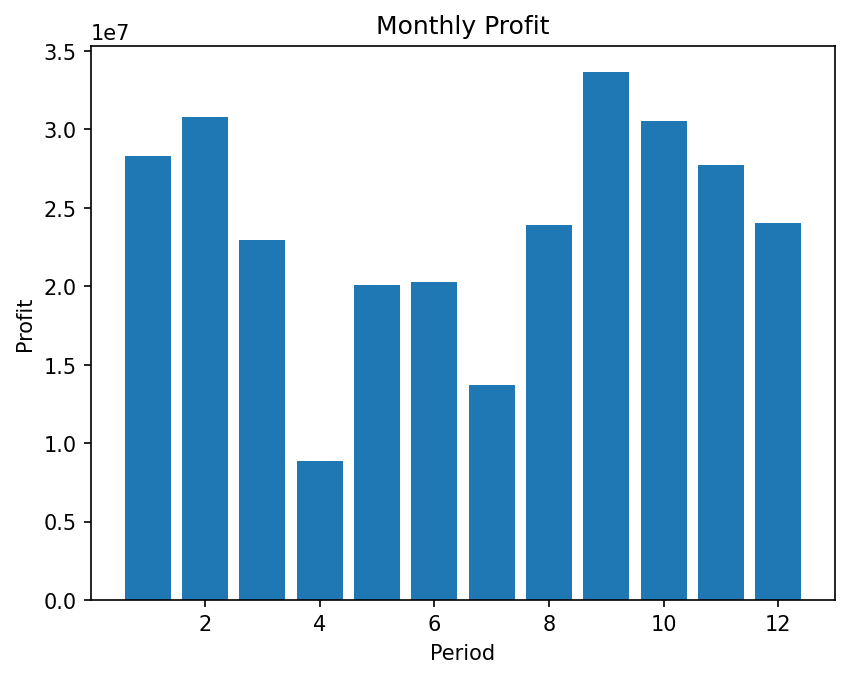

In [19]:
if is_feasible:
    plt.figure(dpi=150)
    plt.bar(x=np.linspace(1, n_periods, n_periods), height=monthly_profit)
    plt.title("Monthly Profit")
    plt.xlabel("Period")
    plt.ylabel("Profit")
    plt.show()
else:
    print("The problem is infeasible.")